In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from plotly import tools
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import plotly.graph_objs as go
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os, json, itertools

from tqdm import tqdm
from sklearn.grid_search import ParameterGrid
from sklearn import *
from copy import deepcopy
from scipy.stats.stats import pearsonr, spearmanr
from shapely.geometry import Polygon
from collections import Counter
from modules import correlation, evaluation, query, residual, visualization

import statsmodels.api as sm
from scipy.stats.mstats import zscore

sns.set(color_codes=True)

loo = model_selection.LeaveOneOut()

data_dir = os.path.join('..','..','data')

In [5]:
def get_detect(df_detect, addrcode, column):
    detect = round(df_detect.loc[df_detect['addrcode'] == addrcode].mean()[column], 2)
    return detect

def get_category(df_residual, addrcode, q1, q2):
    value = df_residual.loc[addrcode]['residual']

    if value > q2: return 'Bad'
    elif value > q1: return 'Average'
    else: return 'Good'


def get_residual_corr(df_detect, df_population, df_area, df_residual, df_gsv_coverage, q1, q2):
    addrcodes = df_residual.index.values
    populations, land_areas, detects, categories, image_areas = [], [], [], [], []
    jars, bins, buckets, pottedplants, tires, bowls = [], [], [], [], [], []
    villages = []
    rainfalls, temperatures = [], []
    for addrcode in addrcodes:
        detects.append(get_detect(df_detect, addrcode, column='total'))
        
        jars.append(get_detect(df_detect, addrcode, column='jar'))
        bins.append(get_detect(df_detect, addrcode, column='bin'))
        buckets.append(get_detect(df_detect, addrcode, column='bucket'))
        tires.append(get_detect(df_detect, addrcode, column='tire'))
        pottedplants.append(get_detect(df_detect, addrcode, column='pottedplant'))
        bowls.append(get_detect(df_detect, addrcode, column='bowl'))
        
        populations.append(query.get_population(df_population, addrcode))
        land_areas.append(query.get_area(df_area, addrcode))
        categories.append(residual.get_category(df_residual, addrcode, q1, q2))
        image_areas.append(query.get_gsv_coverage(df_gsv_coverage, addrcode))
        
        villages.append(get_n_village(df_survey, dengue_season, addrcode))
        
        rainfalls.append(get_rainfall(df_rainfall, addrcode))
        temperatures.append(get_temperature(df_temperature, addrcode))

    df_residual_corr = df_residual.copy()
    
    df_residual_corr['n_villages'] = villages
    
    df_residual_corr['bs_counts'] = detects
    
    df_residual_corr['jars'] = jars
    df_residual_corr['bins'] = bins
    df_residual_corr['buckets'] = buckets
    df_residual_corr['tires'] = tires
    df_residual_corr['pottedplants'] = pottedplants
    df_residual_corr['bowls'] = bowls
    
    df_residual_corr['category'] = categories
    df_residual_corr['population'] = populations
    df_residual_corr['land_area'] = land_areas
    df_residual_corr['image_area'] = image_areas
    
    df_residual_corr['rainfall'] = rainfalls
    df_residual_corr['temperature'] = temperatures
    df_residual_corr['rainfall_density'] = df_residual_corr['rainfall']/df_residual_corr['land_area']
    df_residual_corr['rainfall_temp'] = df_residual_corr['rainfall']/df_residual_corr['temperature']

    
#     df_residual_corr['jars_density'] = df_residual_corr['jars']/df_residual_corr['land_area']
#     df_residual_corr['bins_density'] = df_residual_corr['bins']/df_residual_corr['land_area']
#     df_residual_corr['buckets_density'] = df_residual_corr['buckets']/df_residual_corr['land_area']
#     df_residual_corr['tires_density'] = df_residual_corr['tires']/df_residual_corr['land_area']
#     df_residual_corr['pottedplants_density'] = df_residual_corr['pottedplants']/df_residual_corr['land_area']
#     df_residual_corr['bowls_density'] = df_residual_corr['bowls']/df_residual_corr['land_area']


    df_residual_corr['gsv_density'] = df_residual_corr['image_area']/df_residual_corr['land_area']
    df_residual_corr['population_density'] = df_residual_corr['population']/df_residual_corr['land_area']
    df_residual_corr['bs_density'] = df_residual_corr['bs_counts']/df_residual_corr['land_area']
    df_residual_corr['survey_coverage'] = 10000*df_residual_corr['n_villages']/df_residual_corr['population']
    df_residual_corr['survey_coverage_2'] = 10000*df_residual_corr['n_villages']/df_residual_corr['land_area']
    df_residual_corr['survey_coverage_3'] = 10000*df_residual_corr['land_area']*df_residual_corr['n_villages']/df_residual_corr['population']
    
#     df_residual_corr['bs_image_density'] = df_residual_corr['bs_counts']/df_residual_corr['image_area']

    df_residual_corr = df_residual_corr.drop(['bs_counts','jars','bins','buckets','tires','pottedplants','bowls',
                                              'image_area','land_area','population','n_villages'], axis=1)
    
    return df_residual_corr

In [6]:
def get_n_village(df_survey, dengue_season, addrcode):
    if dengue_season:
        months = [6,7,8,9,10,11]
    else:
        months = [1,2,3,4,5,6,7,8,9,10,11,12]

    n_village = len(df_survey.loc[
        (df_survey['addrcode'] == addrcode) &
        (df_survey.index.month.isin(months))
    ].groupby('village').mean())
    
    return n_village

In [7]:
# Load Surveys Data
df_survey = pd.read_csv(os.path.join(data_dir,'breeding-sites','csv','full-info','larval-survey.csv'))
df_survey = df_survey.replace(0, np.nan)
df_survey = df_survey.dropna(axis=0, how='any')
df_survey = df_survey.reset_index(drop=True)
df_survey['addrcode'] = df_survey['addrcode'].astype('int')
df_survey['date'] = pd.to_datetime(df_survey['date'], format='%Y-%m')
df_survey = df_survey.set_index('date')
df_survey = df_survey.sort_index()
df_survey = df_survey['2015':'2017']
df_survey = query.filter_survey(df_survey, index='bi')
df_survey.head(1)
# print('Total data points:',len(df_survey))

# Load Detected Breeding Sites
df_detect = pd.read_csv(os.path.join(data_dir,'breeding-sites','csv','addrcode-index','detection.csv')) 
df_detect['date'] = pd.to_datetime(df_detect['date'], format='%Y-%m')
df_detect['addrcode'] = df_detect['addrcode'].astype('int')
df_detect = df_detect.set_index('date')
df_detect = df_detect.sort_index()
df_detect.head(1)
# print('Total data points:',len(df_detect))

# Area
df_area = pd.read_csv(os.path.join(data_dir,'shapefiles','csv','subdistricts-area.csv')) 
df_area['addrcode'] = df_area['addrcode'].astype('int')
df_area.head(1)
# print('Total data points:',len(df_area))

# Population 
df_population = pd.read_csv(os.path.join(data_dir,'population','addrcode-index','population.csv')) 
df_population['addrcode'] = df_population['addrcode'].astype('int')
df_population.head(1)
# print('Total data points:',len(df_population))

# Dictionary File 
df_dictionary = pd.read_csv(os.path.join(data_dir,'shapefiles','csv','addrcode-dictionary.csv')) 
df_dictionary['addrcode'] = df_dictionary['addrcode'].astype('int')
df_dictionary.head(1)

# GSV Coverage
df_gsv_coverage = pd.read_csv(os.path.join(data_dir,'shapefiles','csv','gsv-coverage.csv')) 
df_gsv_coverage['addrcode'] = df_gsv_coverage['addrcode'].astype('int')
df_gsv_coverage.head(1)

df_rainfall = pd.read_csv(os.path.join(data_dir,'weather','csv','rainfall.csv')) 
df_rainfall['addrcode'] = df_rainfall['addrcode'].astype('int')
df_rainfall['date'] = pd.to_datetime(df_rainfall['date'], format='%Y-%m')
df_rainfall = df_rainfall.set_index('date')
df_rainfall = df_rainfall['2015':'2017']
df_rainfall = df_rainfall.set_index('addrcode')
df_rainfall = df_rainfall.sort_index()
df_rainfall = df_rainfall.drop('rainfall_sum', axis=1)
df_rainfall.columns = ['rainfall']
df_rainfall = df_rainfall.groupby('addrcode').sum()
df_rainfall.head(1)

df_temperature = pd.read_csv(os.path.join(data_dir,'weather','csv','temperature.csv')) 
df_temperature['addrcode'] = df_temperature['addrcode'].astype('int')
df_temperature['date'] = pd.to_datetime(df_temperature['date'], format='%Y-%m')
df_temperature = df_temperature.set_index('date')
df_temperature = df_temperature['2015':'2017']
df_temperature = df_temperature.set_index('addrcode')
df_temperature = df_temperature.sort_index()
df_temperature.columns = ['temperature']
df_temperature = df_temperature.groupby('addrcode').mean()
df_temperature.head(1)

### Load Shapefile
with open(os.path.join(data_dir,'shapefiles','geojson','Nakhon-subdistricts.geojson')) as f:
    data_polygon = json.load(f)
data_polygon['features'][0]['properties']

### Detection Statistic
print('\n')
detect_stat = dict()
for province_id in [10,80,81]:
    tmp = df_detect.loc[(df_detect['addrcode'] > province_id*10000) & (df_detect['addrcode'] < (province_id+1)*10000)]['total'].copy()
    mean_det, std_det = round(tmp.mean(),2), round(tmp.std(),2)
    detect_stat[str(province_id)] = [mean_det, std_det]
    print('Province', province_id, ': Mean', mean_det,', SD', std_det)
print(detect_stat)

,addrcode,province,district,subdist,village,hi,ci,bi,province_EN,district_EN,subdist_EN
date,,,,,,,,,,,
2015-01-01,810305,กระบี่,เกาะลันตา,ศาลาด่าน,ศาลาด่าน,13.0,5.39,22.0,Krabi,Ko Lanta,Sala Dan


,addrcode,bin,bowl,bucket,cup,jar,pottedplant,tire,vase,total
date,,,,,,,,,,
2011-12-01,103802,270,15,829,9,71,2246,165,4,3609


,addrcode,area
0,100101,14.11


,addrcode,population
0,800101,43678


,addrcode,subdistrict_th,subdistrict_en,district_code,district_th,district_en,province_code,province_th,province_en,LAT,LONG,Population
0,100101,พระบรมมหาราชวัง,Phra Borom Maha Ratchawang,1001,พระนคร,Phra Nakhon,10,กรุงเทพมหานคร,Bangkok,13.751,100.492,4089


,addrcode,land_area,image_area
0,100508,212.97,194.85


,rainfall
addrcode,
8101,15512.96


,temperature
addrcode,
8101,0.0


{'AP_EN': 'Phrom Khiri',
 'AP_IDN': '8002',
 'AP_TN': 'พรหมคีรี',
 'PV_EN': 'Nakhon Si Thammarat',
 'PV_IDN': '80',
 'PV_TN': 'นครศรีธรรมราช',
 'TB_EN': 'Thon Hong',
 'TB_TN': 'ทอนหงส์',
 'addrcode': '800204'}



Province 10 : Mean 1854.7 , SD 2193.71
Province 80 : Mean 506.64 , SD 432.66
Province 81 : Mean 638.83 , SD 353.85
{'10': [1854.7, 2193.71], '80': [506.64, 432.66], '81': [638.83, 353.85]}


In [8]:
def get_rainfall(df_rainfall, addrcode):
    if addrcode in df_rainfall.index:
        return df_rainfall.loc[addrcode]['rainfall']
    return df_rainfall['rainfall'].mean()

def get_temperature(df_temperature, addrcode):
    if addrcode in df_temperature.index:
        return df_temperature.loc[addrcode]['temperature']
    return df_temperature['temperature'].mean()

def get_survey(df_survey, dengue_season, addrcode, months):

    survey = round(df_survey.loc[
        (df_survey['addrcode'] == addrcode) &
        (df_survey.index.month.isin(months))
    ]['bi'].mean(), 2)

    return survey

def residual_corr_plot(df_residual_corr, title, y_col, y_axis_name, x_axis_name, out_filename):
    flatui = ["#2ecc71","#34495e",  "#e74c3c"]
    _=plt.figure(figsize=((10,10)))
    _=sns.set_context("poster", font_scale = 0.8)
    fig = sns.FacetGrid(data=df_residual_corr, hue="category", size=8, hue_order=["Good", "Average", "Bad"], palette=sns.color_palette(flatui), hue_kws=dict(marker=["o", "D","s"]))\
        .map(plt.scatter, "residual", y_col) \
        .add_legend() 
    fig = sns.regplot(x="residual", y=y_col, data=df_residual_corr, scatter=False)
    
    X = df_residual_corr.residual.values
    y = df_residual_corr[y_col].values
    
    pearson_val = pearsonr(X, y)
    spearman_val = spearmanr(X, y)

    _=fig.set_title(
        title+ \
        '\nPearson: '+str(round(pearson_val[0],4))+ ', p-value: '+str(round(pearson_val[1],4))+ \
        '\nSpearman: '+str(round(spearman_val[0],4))+', p-value: '+str(round(spearman_val[1],4))
    )
    _=fig.set_xlabel(x_axis_name)
    _=fig.set_ylabel(y_axis_name)

    _=fig.figure.savefig(out_filename+'.svg', bbox_inches='tight')
    _=fig.figure.savefig(out_filename+'.png', bbox_inches='tight')

def plot_residual_heatmap(residuals):
    df_residual = pd.DataFrame(np.append(names.reshape(-1,1), residuals.reshape(-1,1), axis=1), columns=['addrcode','residual'])
    df_residual['addrcode'] = df_residual['addrcode'].astype(int)
    df_residual = df_residual.set_index('addrcode')

    q1 = df_residual.describe().loc['25%']['residual']
    q2 = df_residual.describe().loc['75%']['residual']

    _=plt.figure(figsize=((8,2)))
    _=sns.set_context("poster", font_scale = 1)
    fig = sns.boxplot(df_residual.residual)
    _ = sns.swarmplot(df_residual.residual, color=".25", size=8)
    _=plt.title('Distribution of Prediction Errors')
    _=fig.set_xlabel('Residual Error')

    df_residual_corr = get_residual_corr(df_detect, df_population, df_area, df_residual, df_gsv_coverage, q1=q1, q2=q2)

    plt.figure(figsize=(16,1.25))
    sns.set(font_scale=1.3)
    sns.heatmap(df_residual_corr.corr().iloc[[0]], annot=True, fmt=".2f", cmap="YlGnBu")
    plt.show()
    
    return df_residual, df_residual_corr, q1, q2

# 2.3 Non Dengue Season - Linear Regression

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

[(-3, 90)]

[(-3, 90)]

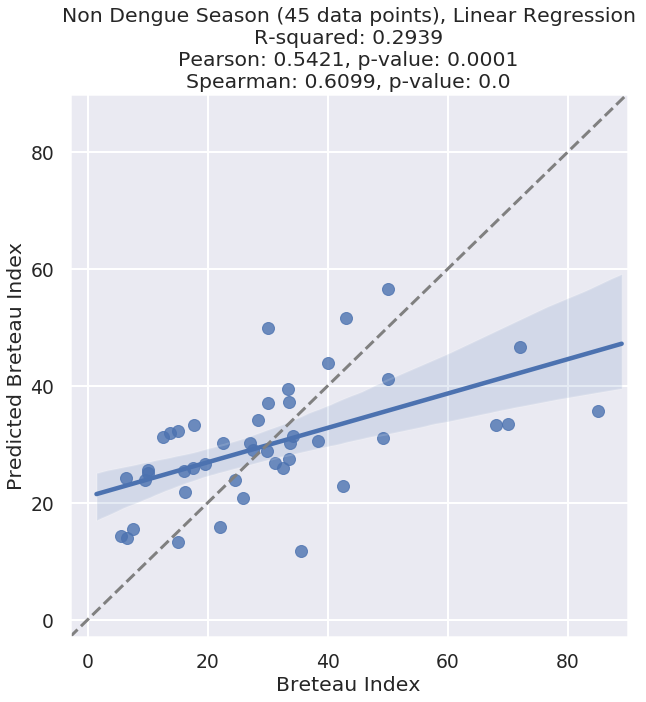

In [173]:
column = 'total'
dengue_season = True
province = '80'
brd_sites=['bin','bowl','bucket','jar','pottedplant','tire','vase','cup']
X, y = [], []
for addrcode in df_survey['addrcode'].unique():

    province_id = str(addrcode)[:2]
    if province_id != province: continue

    mean_det, std_det = detect_stat[province_id]

    detect = query.get_detect(df_detect, addrcode)
    
#     months = [1,2,3,4,5,6,7,8,9,10,11,12]
#     months = [6,7,8,9,10,11]
    months = [1,2,3,4,5,12]
    survey = get_survey(df_survey, dengue_season, addrcode, months)
    area = query.get_area(df_area, addrcode)

    if np.isnan(detect) or np.isnan(survey): continue
    if detect > mean_det+1*std_det or detect < mean_det-1*std_det: continue
        
    detect = query.get_detect(df_detect, addrcode, brd_sites)
    detect = np.squeeze(detect.values)/area

    X.append(detect)
    y.append(survey)
    
X, y = np.array(X), np.array(y)

regr = linear_model.LinearRegression()

regr.fit(X,y)
r2 = regr.score(X,y)

y_true, y_pred = np.array(y), regr.predict(X)

pearson_val = pearsonr(y_true, y_pred)
spearman_val = spearmanr(y_true, y_pred)

_=plt.figure(figsize=((10,10)))

_=sns.set_context("poster", font_scale = 0.85)

fig = sns.regplot(y_true,y_pred, fit_reg=True)
_=fig.set_title(
'Non Dengue Season ('+str(len(X))+' data points), Linear Regression'+ \
    '\nR-squared: '+str(round(r2,4)) + \
    '\nPearson: '+str(round(pearson_val[0],4))+ ', p-value: '+str(round(pearson_val[1],4))+ \
    '\nSpearman: '+str(round(spearman_val[0],4))+', p-value: '+str(round(spearman_val[1],4))
)
_=fig.set_xlabel('Breteau Index')
_=fig.set_ylabel('Predicted Breteau Index')
_=plt.plot([-3, 90],[-3,  90],color='gray', lw=3, linestyle='--')
fig.set(xlim=(-3, 90))
fig.set(ylim=(-3, 90))

_=fig.figure.savefig('BI-results-v2/2-ndc-norm_bs.svg', bbox_inches='tight')
_=fig.figure.savefig('BI-results-v2/2-ndc-norm_bs.png', bbox_inches='tight')